In [254]:
import speech_recognition as sr
import youtube_dl
import xml.etree.ElementTree as ET
from nltk.tokenize import sent_tokenize, word_tokenize
import soundfile as sf
from nltk import FreqDist
import nltk
from nltk.collocations import*
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import requests
import pandas as pd
from aylienapiclient import textapi
import numpy as np
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.cluster.util import cosine_distance
from operator import itemgetter
import urllib

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zeugn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Derive text from youtube subtitle url 

Found like this: browser --> settings --> more tools --> dev tools --> type timed --> press cc --> network --> header --> copy url

In [2]:
def clean_text(text):
    return text.strip().replace("\n", " ")

def get_text(url):
    handle = urllib.request.urlopen(url)
    content = handle.read()
    root = ET.fromstring(content)
    #root = tree.getroot()
    running_words = []
    body = root.find('body')
    for p in body.findall('p'): #what does the p stand for
        if p.text is None or p.text == "\n":
                words = [clean_text(s.text) for s in p.findall("s")]
        else:
            words = [clean_text(p.text)]
        running_words.extend(words)
    final_text = " ".join(running_words)
    return final_text

In case the download with the following youtube_dl does not work we can still get the text from the youtube subtitle

#### Download video/audio file 

In [30]:
# create a downloader

class logger(object):
    def debug(self, msg):
        pass
    def warning(self, msg):
        pass
    def error(self, msg):
        print(msg)
        
def hook(d):
    if d['status'] == 'finished':
        result = d['filename']
        print('download finished')
        print(result)

def download(url):
    options = { 
            'format': 'bestaudio/best',
            'postprocessors': [{
            'key':'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
            }],
            'logger': logger(),
             'progress_hooks': [hook],
            }
              
    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([url])

In [38]:
#as a sample case I have used "the economic machine" by Ray dalio --> https://www.youtube.com/watch?v=PHe0bXAIuk0
url = str(input('Please enter a url from which you want to download a video '))

Please enter a url from which you want to download a videohttps://www.youtube.com/watch?v=PHe0bXAIuk0


In [42]:
download(url)

download finished
How The Economic Machine Works by Ray Dalio-PHe0bXAIuk0.webm


#### Read in the downloaded audio file and calculate length of audio file

In [43]:
file = 'How The Economic Machine Works by Ray Dalio-PHe0bXAIuk0.wav'
f = sf.SoundFile(file) #read in audio file
video_length = int(len(f) / f.samplerate) + (len(f)%f.samplerate > 0)    #round up to make sure we get the entire file
video_length #video length in seconds

1860

In [259]:
loop_number = int(video_length/10) + (video_length% 10 >0) #calculate the number of required loops
if loop_number == 0:
    loop_range= 2
else:
    loop_range = int((loop_number/2))

93

In [264]:
#create a function that loops through the audio file and transcribes
def transcribe(loops, starting_increment):
    audio_text1 = [] 
    increment = starting_increment 
    for i in range(loops):
        r = sr.Recognizer()
        with sr.AudioFile(file) as source:
            audio = r.record(source, offset = (increment) , duration= 10)
        string = r.recognize_google(audio)
        audio_text1.append(string)
        increment += 10
    return audio_text1

In [ ]:
audio_text1 = transcribe(loop_range, start)
audio_text2 = transcribe(loop_range, loop_range)

In [65]:
half1_audio = " ".join(audio_text1)
half2_audio = " ".join(audio_text2)
full_text = half1_audio + " " + half2_audio

#### Word Analysis: Frequency, Bigram, and Wordcloud

obtain the most frequently used words

In [84]:
nltkstopwords = nltk.corpus.stopwords.words('english')
otherstopwords = ['could','would','might','must','need', 'sha','wo','y', "'s", "'d", "'ll", "'t", "'re" ]
stopwords = nltkstopwords + otherstopwords
token = nltk.word_tokenize(full_text) #all words within text
words = [w.lower() for w in token] # converted to lowercase
vocab = sorted(set(words)) #unique words/vocabulary used
stoppedtokens = [w for w in words if not w in stopwords] #filter out stopwords without any meaning
fdist = FreqDist(stoppedtokens)
fdistkeys = list(fdist.keys())
topkeys = fdist.most_common(50) #the 50 most frequent words used in given text

obtain the most frequent bigrams used

In [90]:
bigrams = list(nltk.bigrams(stoppedtokens))
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(stoppedtokens)
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:10] #the top 10 most often occuring bigrams

[(('interest', 'rates'), 0.005475989890480202),
 (('person', 'income'), 0.005475989890480202),
 (('another', 'person'), 0.005054759898904802),
 (('debt', 'cycle'), 0.005054759898904802),
 (('spending', 'another'), 0.005054759898904802),
 (('increase', 'spending'), 0.004633529907329402),
 (('ca', "n't"), 0.003369839932603201),
 (('central', 'bank'), 0.003369839932603201),
 (('pay', 'back'), 0.003369839932603201),
 (('prices', 'rise'), 0.003369839932603201)]

Wordcloud implementation of most frequent words

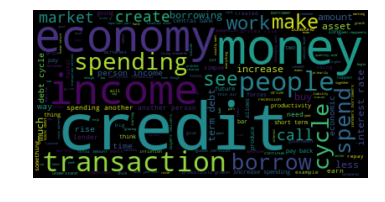

In [99]:
wordcloud = WordCloud().generate(full_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

 Word Sentiment - get positive and negative words 

In [106]:
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]
for word in vocab:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)  
print('Positive :',pos_word_list)          
print('Negative :',neg_word_list)

Positive : ['best', 'comfortable', 'creditworthy', 'great']
Negative : ['bad', 'crisis', 'death', 'hated', 'war']


#### Add punctuation for sentence


In [109]:
url_punctuator = 'http://bark.phon.ioc.ee/punctuator'
r = requests.post(url_punctuator, data = {'text': full_text})
text_punctuated = r.text

#### Sentiment Analysis - Sentences

In [134]:
sentences = sent_tokenize(text_punctuated)
df = pd.DataFrame(sentences)
analyser = SentimentIntensityAnalyzer()
results = []
for sent in sentences:
    score = analyser.polarity_scores(sent)
    score['description'] = sent
    results.append(score)
df_scores = pd.DataFrame(results)

In [272]:
df_scores['label'] = 0
df_scores.loc[df_scores['compound'] > 0.2, 'label'] = 1
df_scores.loc[df_scores['compound'] < -0.2, 'label'] = -1
df_sorted1 = df_scores.sort_values(by='compound', ascending = False) #sorted by positive sentences
df_sorted2 = df_scores.sort_values(by='compound') #sorted by negative sentences
print('Number of positive words:' + str(len(df_scores[df_scores['label']==1]))) #number of positive sentences
print('Number of negative words:' + str(len(df_scores[df_scores['label']==-1]))) #number of negative sentences
print('Number of neutral words:' + str(len(df_scores[df_scores['label']==0]))) #number of neutral sentences

Number of positive words:108
Number of negative words:37
Number of neutral words:78


#### Use Alyien API for Text Summarization purposes

In [165]:
sentence_number = str(input("How many sentences should the summary be comprised of?"))
client = textapi.Client("7d35019d", "da268fc79ce12e5ebe9c6e070ded342b")
summary = client.Summarize({'text': text_punctuated , 'title': 'Summary', 'sentences_percentage':sentence_number }) 
summary['sentences'][:3]


How many sentences should the summary be comprised of?15


['These transactions are, above all else, driven by human nature, and they create three main forces that drive the economy number one productivity growth number to the the term debt cycle and number three.',
 'Each transaction consists of a buyer, exchanging money or credit with a seller for goods services for financial assets, credit spins, just like money, so adding together the money spent and the amount of credit spent.',
 'The way I just described exchanging money and credit for goods, services and financial assets, the biggest Byron seller, is the government which consists of two important parts: a central government that collects taxes and spends money and a central bank which different from other buyers and sellers, because It controls the amount of money and Credit in the economy.']

#### Write Summarization to txt file

In [ ]:
with open('text_summary.txt', 'w') as x:
    for i in summary['sentences']:
        x.write(i)
        print(i)

### Other Summarization Approaches

#### Using page rank algorithm to determine sentence importance

In [218]:
def findSentenceSimilarity(s1, s2):
    allWords = list(set(s1 + s2))
    vectorForS1 = [0] * len(allWords)
    vectorForS2 = [0] * len(allWords)
    for word in s1:
        vectorForS1[allWords.index(word)] += 1
    for word in s2:
        vectorForS2[allWords.index(word)] += 1
    return 1 - cosine_distance(vectorForS1, vectorForS2)

In [219]:
def createSimilarityMatrix(sentences):
    matrix = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i == j:
                continue
            else:
                matrix[i][j] = findSentenceSimilarity(sentences[i], sentences[j])
    for i in range(len(matrix)):
        matrix[i] /= matrix[i].sum()
    return matrix

In [220]:
SimilarityMatrix = createSimilarityMatrix(sentences)

In [221]:
def pagerank(matrix, eps=1.0e-8, d=0.85):
    N = matrix.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * np.inf
    M_hat = (d * matrix) + (((1 - d) / N) * np.ones((N, N), dtype=np.float32))
    
    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = np.matmul(M_hat, v)
    return v

In [222]:
ranks = pagerank(SimilarityMatrix)

In [251]:
sortRankWithindexes = [item[0] for item in sorted(enumerate(ranks), key=lambda item: -item[1])]


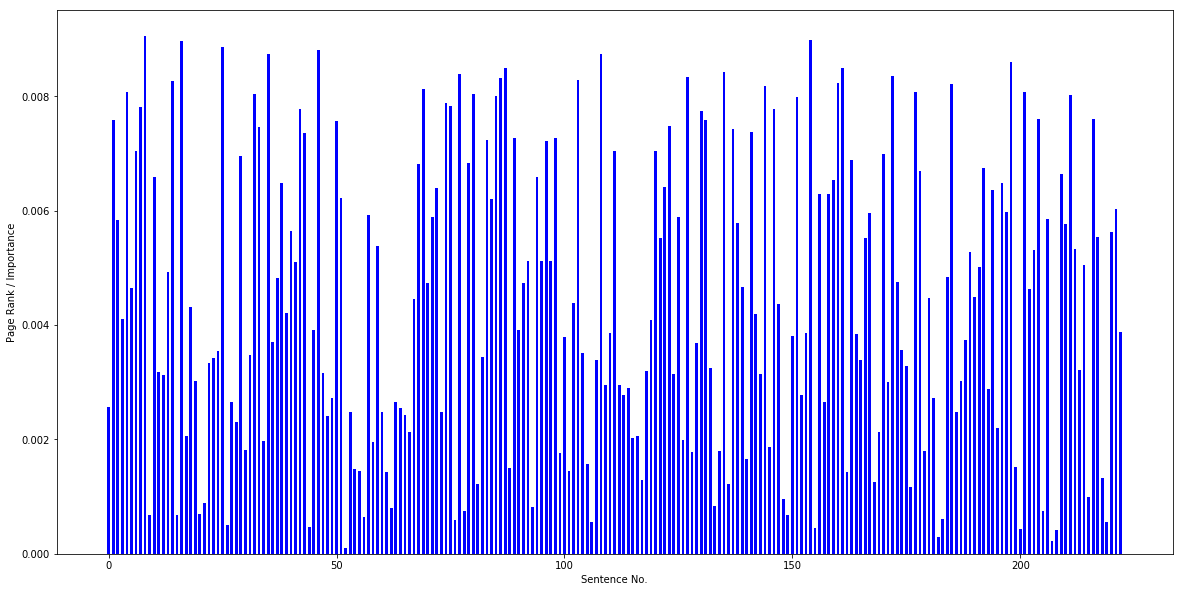

In [253]:
plt.figure(figsize=(20, 10))
plt.bar([item[0] for item in sorted(enumerate(ranks))], ranks.T[0],color='blue',width=0.6)
plt.ylabel("Page Rank / Importance")
plt.xlabel("Sentence No.")
plt.show()

In [248]:
summary_lines = int(input('How many sentences do you want your summary to be comprised of? '))
selectedSentences = sorted(sortRankWithindexes[:summary_lines])
summary = itemgetter(*selectedSentences)(sentences)
finalSummary=""
for sentence in summary:
    finalSummary+=''.join(sentence)

How many sentences do you want your summary to be comprised of? 10


In [249]:
finalSummary

"Transaction economy is simply the sum of the transactions that make it up, and a transaction is a very simple thing.So if we can understand transactions, we can understand the whole economy.For these reasons, as well see the central bank is an important player in the flow of credit to pay attention to credit credit is the most important part of the economy and probably the least understood it's the most important part, because it's the best and most volatile Part, just like buyers and sellers go to the market to make transactions soda lenders and Borrowers lenders usually want to make their money into more money, and borrowers usually want to buy something they can't afford, like a house or a car where they want, invest in something.So when you spend more, someone else earns more when someone's income Rises, it makes lenders more willing to lend him money because now he's more worthy of credit, a credit worthy bar or has two things: the ability-to-repay and collateral having a lot of 